# Environment Examples
Simple examples of using environment cues to guide growth. All methods use error detection to guide or finish growth.  

- finding other neurons: using the ``get_fronts`` method to detect another neuron type and grow towards it: [Demo_attraction](#Demo_attraction)
- collision avoidance: using ``CollisionError`` to detect an obstructing front and go around it: [Avoidance](#Avoidance)
- using ``Substrate``, these methods also demonstrate use of an additional attribute:
    - very simple, substrate is just a location to grow to: [Simple_gradient_follower](#Simple_gradient_follower)
    - diffusion based with a stochastic gradient: [Diff_amount_gradient_follower](#Diff_amount_gradient_follower)

## Demo_attraction
A growing dendrite is attracted towards another neuron type. Demonstrates the use of the ``get_fronts`` method to find information about other neurons. For some seeds the *AttractFront* is positioned too far from the *GrowToFront* and ``get_fronts`` does not find it with the default ``max_distance=100`` setting.  
This code makes use of errors to finish growth:
- ``CollisionError`` to make ``GrowToFront`` stop growing its axon upon arrival at ``AttractFront``.
- ``VolumeError`` to make ``AttractFront`` stop growing its axon.

<IPython.core.display.Javascript object>


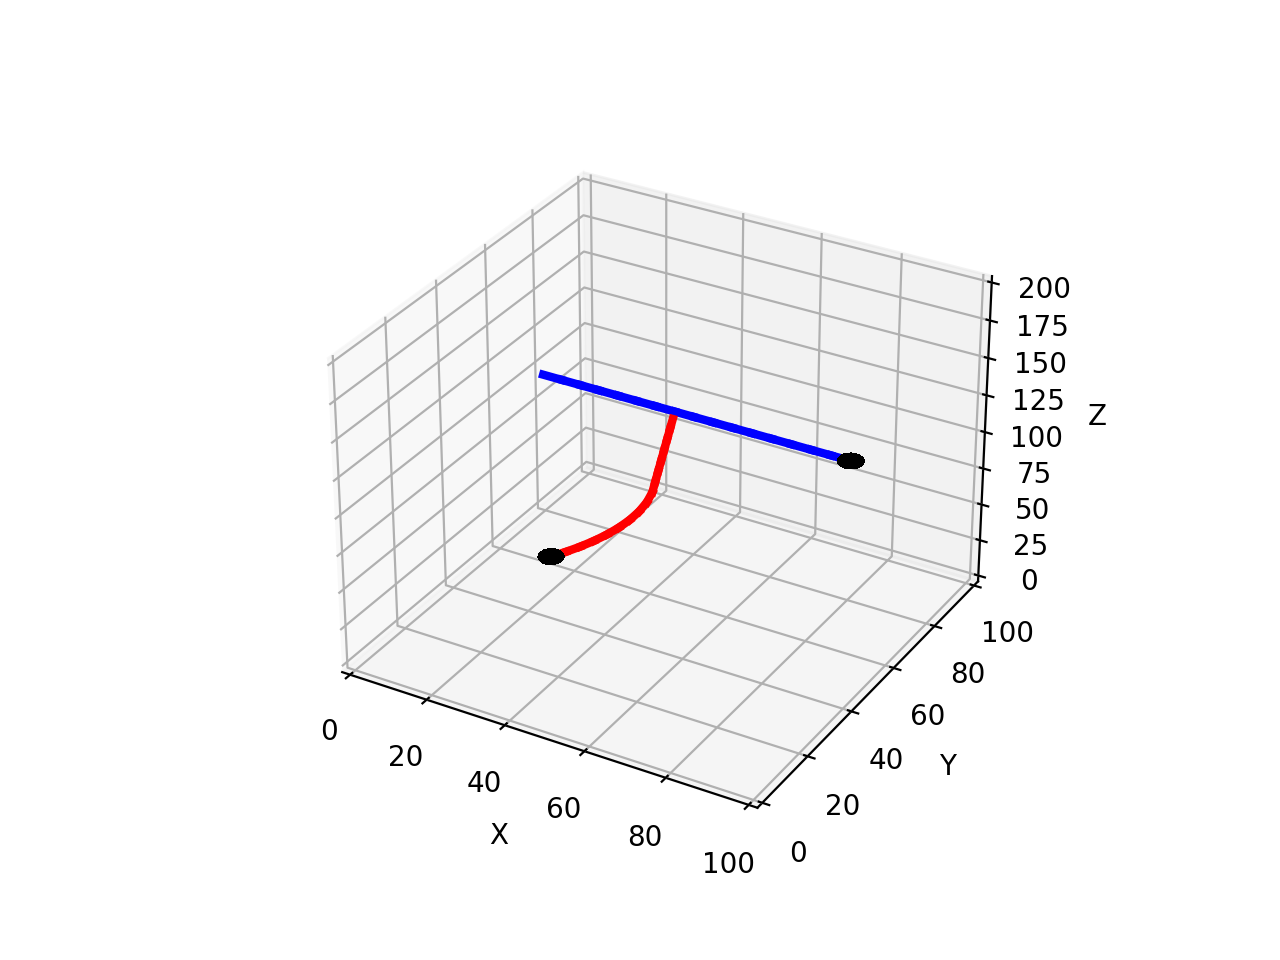

attract_neuron Z coordinate: 92.5533007053861


In [1]:
%matplotlib notebook

from neurodevsim.simulator import *

# This subclass actively seeks the other one
class GrowToFront(Front):

    def manage_front(self,constellation):
        # get list of fronts with name "attract_neuron":
        #  returns [(front,distance),(front,distance),...] sorted by increasing distance
        goals = self.get_fronts(constellation,what="name",name="attract_neuron")
        # use first of the list
        if goals:
            goal_front = goals[0][0]
            dir_to_goal = goal_front.end - self.end
        else: # not within 100 µm (default max_distance)
            print ("Too far from attract_neuron")
            dir_to_goal = Point(1.0,0.,0.)
        length = 5.0 # standard length of front
        while length > 0.:
            new_pos = self.end + dir_to_goal.norm() * length
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.5,swc_type=2) # make a new front and store it
                # make front inactive: stops growing -> will not call this method again
                self.disable(constellation)
                if length < 5. : # last front made -> no more growth
                    new_front.disable(constellation)
                return # done for this cycle
            except (CollisionError):
                # close enough to attract_neuron to cause a collision -> decrease length
                length -= 0.5
                if length == 0.: # close enough -> stop growth
                    self.disable(constellation)
                    return # done for this cycle
            except (GridCompetitionError, InsideParentError, VolumeError) as error:
                # in this simple simulation no errors should occur
                print ("   ",error)
                self.disable(constellation)
                return # done for this cycle

# This subclass is the passive attractor
class AttractFront(Front):

    def manage_front(self,constellation):
        # this structure grows straight without contextual interaction
        new_pos = self.end + Point(-5.0,0.,0.)
        try:
            new_front = self.add_child(constellation,new_pos,radius=1.5,swc_type=2) # make a new front and store it
            # make front inactive: stops growing -> will not call this method again
            self.disable(constellation)
            return # done for this cycle
        except VolumeError:
            # this error is expected: reached volume border -> stop growth
            self.disable(constellation)
            return # done for this cycle
        except (CollisionError, GridCompetitionError, InsideParentError):
            # in this simple simulation no errors should occur
            self.disable(constellation)
            return # done for this cycle


if __name__ == '__main__':

    fname = "output/demo_attraction.db"
    sim_volume = [[0., 0., 0.], [100., 100., 200.]]
    neuron_types = [GrowToFront,AttractFront]
    admin = Admin_agent(1,fname,sim_volume,neuron_types,verbose=0,seed=1,plot=True)
    admin.add_neurons(GrowToFront,"grow_neuron",1,[[20,50,20],[20,50,20]],3)
    
    z = 30. + np.random.random() * 150. # random z position for attract_neuron
    print ("attract_neuron Z coordinate:",z)
    admin.add_neurons(AttractFront,"attract_neuron",1,[[80.,80.,z],[80.,80.,z]],3)

    admin.simulation_loop(25)

    admin.destruction()



## Avoidance
A growing dendrite has to find a way around a big dendrite belonging to another neuron. This obstruction is detected using ``ColissionError`` and the obstruction provides repulsion to the direction of growth. This repulsion may cause an ``InsideParentError``, then a random direction is tried.

<IPython.core.display.Javascript object>


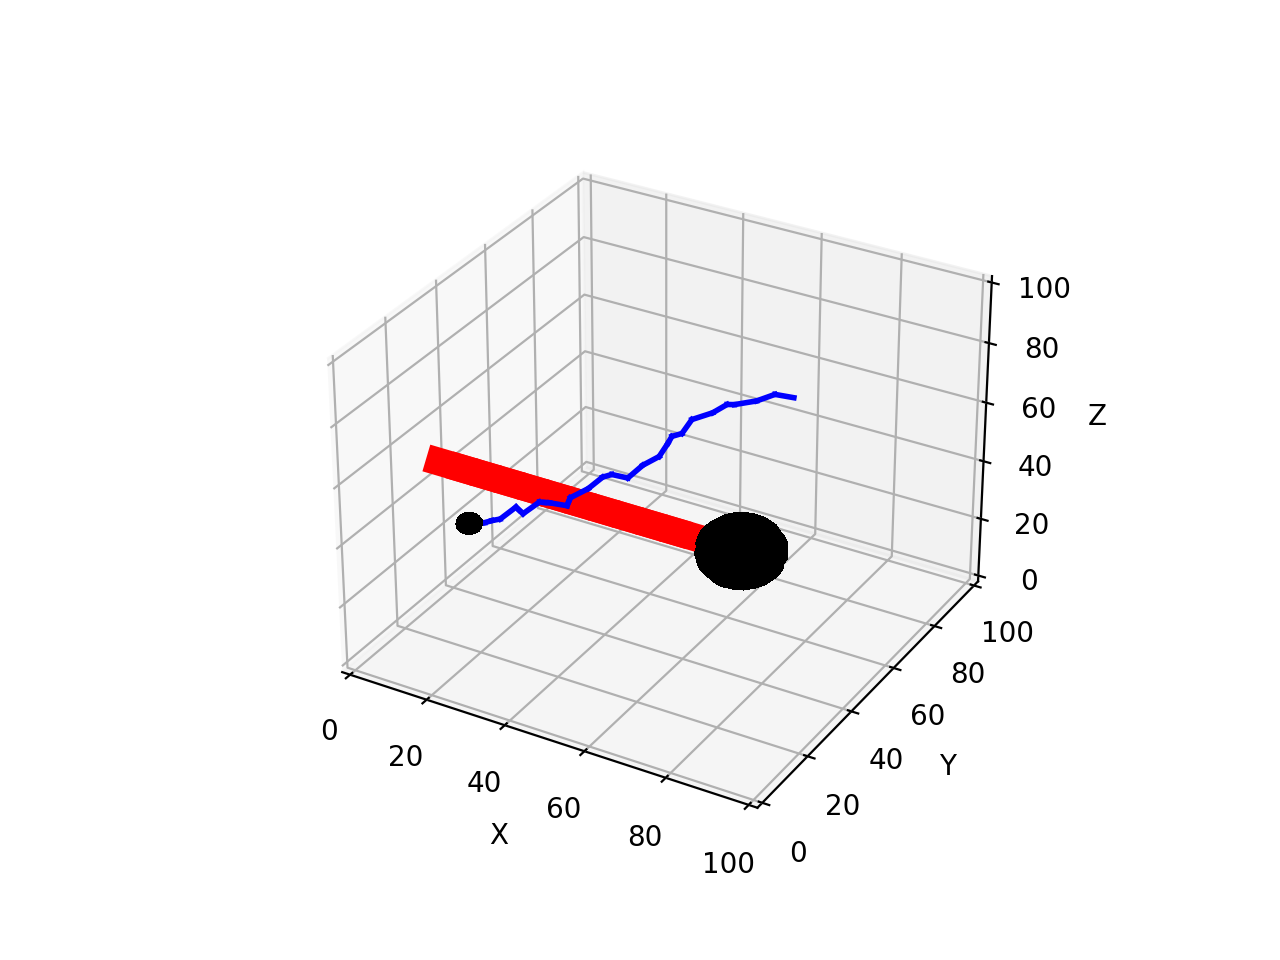

In [2]:
%matplotlib notebook

from neurodevsim.simulator import *

target = Point(200.,30.,200.) # artificial point to grow to

# This subclass does the collision avoidance
class RepelledFront(Front):
    
    def manage_front(self,constellation):
        # compute step to target:
        dir_to_target = target - self.end
        # go to target with a bit of noise added
        new_dir = dir_to_target.norm() * 2. + unit_sample_on_sphere()
        count = 0 # count trials
        avoid = False # random growth mode
        while count < 100:
            if avoid: # collision occurred -> repelled by collider
                new_dir = dir_to_target.norm() - dir_to_repel.norm() + unit_sample_on_sphere() * rand_scale
                new_pos = self.end + new_dir.norm() * 1.2
            else: # default random growth
                new_pos = self.end +  new_dir.norm() * 5.0
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.) # make a new front and store it
                # make front inactive: stops growing -> will not call this method again
                self.disable(constellation)
                return # done for this cycle
            except CollisionError as error:
                dir_to_repel = error.collider.mid() - self.end # repel from collider mid-point
                avoid = True
                rand_scale = count * 0.1 # small random noise initially
                count += 1
                continue
            except VolumeError:
                # this error is expected: reached volume border -> stop growth
                self.disable(constellation)
                return # done for this cycle
            except (GridCompetitionError,InsideParentError):
                count += 1
                continue
        self.disable(constellation) # failed


# This subclass just provides an obstruction
class RepelFront(Front):
    
    def manage_front(self,constellation):
        if self.order > 0: # regular extension
            new_pos = self.end + Point(-6.0,0.,0.)
        else: # first segment: add soma radius
            new_pos = self.end + Point(-16.0,0.,0.)
        try:
            new_front = self.add_child(constellation,new_pos,radius=5.) # make a new front and store it
            # make front inactive: stops growing -> will not call this method again
            self.disable(constellation)
            return # done for this cycle
        except VolumeError:
            # this error is expected: reached volume border -> stop growth
            self.disable(constellation)
            return # done for this cycle
        except (CollisionError,GridCompetitionError, InsideParentError):
            # in this simple simulation no errors should occur
            self.disable(constellation)
            return # done for this cycle


if __name__ == '__main__':

    fname = "output/avoidance.db"
    sim_volume = [[0., 0., 0.], [100., 100., 100.]]
    neuron_types = [RepelledFront,RepelFront]
    admin = Admin_agent(2,fname,sim_volume,neuron_types,verbose=0,seed=5,plot=True)
    
    admin.add_neurons(RepelFront,"repeller",1,[[80,30,50],[80,30,50]],10)
    
    admin.simulation_loop(10)

    admin.add_neurons(RepelledFront,"repelled",1,[[10,32,30],[10,32,30]],3)

    admin.simulation_loop(90)

    admin.destruction()

## Simple_gradient_follower
This very simple model uses ``Substrate`` to define a direction of growth. The location of the substrate is detected and converted to a direction.

<IPython.core.display.Javascript object>


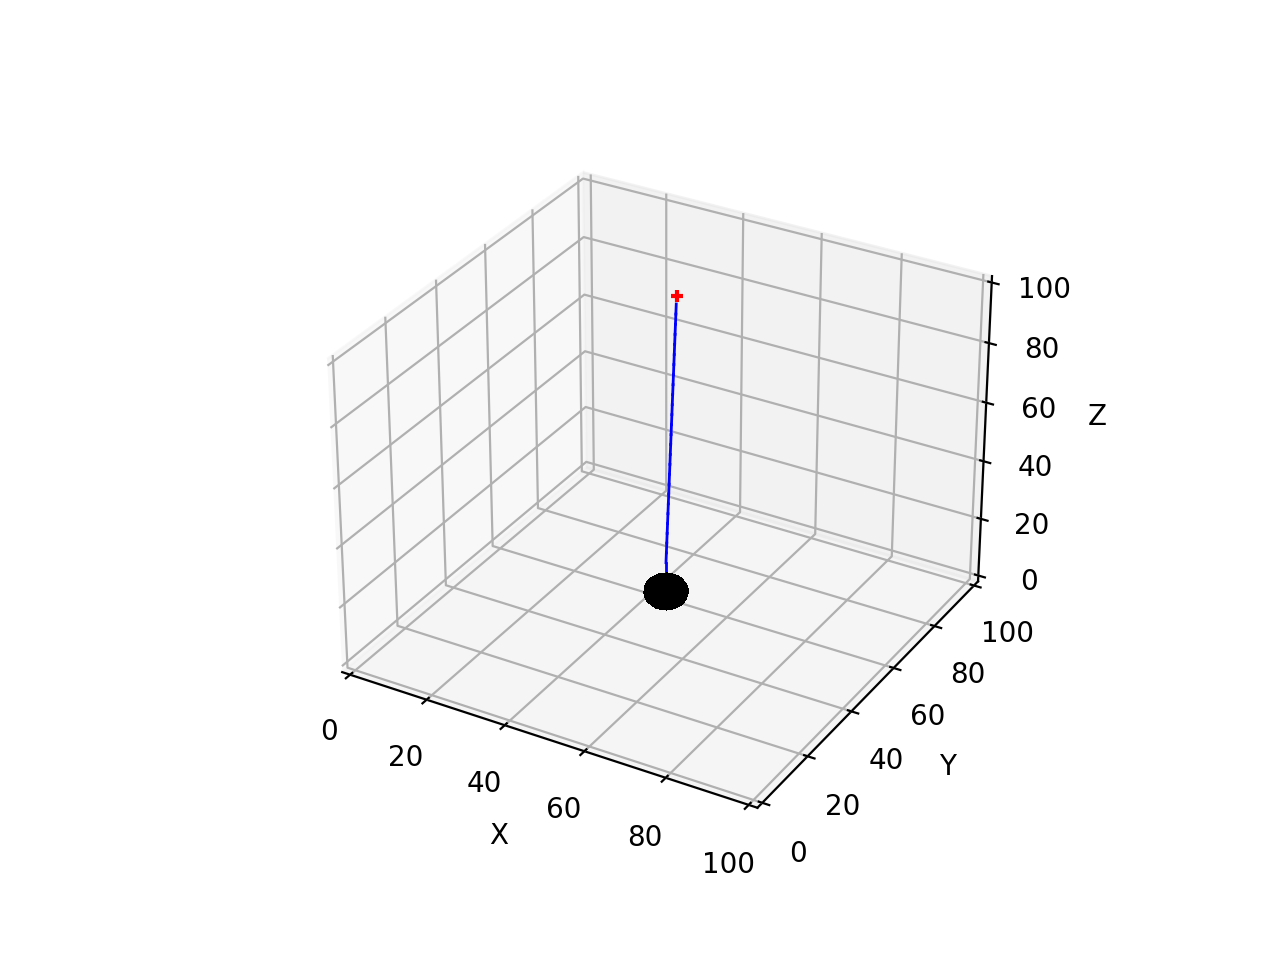

In [3]:
%matplotlib notebook

from neurodevsim.simulator import *

class SGradientFront(Front):
    _fields_ = Front._fields_ + [('sub_ID', ID)]

    def manage_front(self,constellation):
        if self.order > 0: # dendrite extension
            # get the attractor stored in sub_ID
            substrate = constellation.substrate_by_id(self.sub_ID)
            # generate a direction toward the attractor
            dir_to_attractor = substrate.orig - self.end
            if dir_to_attractor.length() < 3.: # arrived
                self.disable(constellation)
                return
            new_pos = self.end + dir_to_attractor.norm() * 3.
        else: # soma
            # first front: always grow upward, otherwise soma may be in between initial front and attractor
            new_pos = self.orig + Point(0.,0.,2 * self.radius)
            # get substrate ID
            substrates = self.get_substrates(constellation,"attractor",returnID=True)
            # substrates is a list: [(substrate_ID,distance),...]
            # in this case we know it contains only a single (substrate_ID,distance) entry
            if substrates: # store substrate ID so that we do not have to repeat get_substrates call
                self.sub_ID = substrates[0][0]
            else:
                print ("Error: no substrate found")
                self.disable(constellation)
                return
        try:
            new_front = self.add_child(constellation,new_pos,radius=0.5) # make a new front and store it
            new_front.sub_ID = self.sub_ID
            # make front inactive: stops growing -> will not call this method again
            self.disable(constellation)
            return # done for this cycle
        except VolumeError:
            # reached volume border -> stop growth
            self.disable(constellation)
            return # done for this cycle
        except (CollisionError, GridCompetitionError, InsideParentError):
            # in this simple simulation no errors should occur
            self.disable(constellation)
            return # done for this cycle
    
if __name__ == '__main__':

    fname = "output/sgradient.db"
    sim_volume = [[0., 0., 0.], [100., 100., 100.]]
    admin = Admin_agent(2,fname,sim_volume,neuron_types=[SGradientFront],verbose=0,seed=1,plot=True)

    # add substrate information, in this case a single random point
    x = 20 + 60 * np.random.random()
    y = 20 + 60 * np.random.random()
    # instantiate a substrate 
    sub = Substrate("attractor",Point(x,y,99.),0,1)
    # add it to the simulation volume
    admin.add_substrate(sub)
    
    admin.add_neurons(SGradientFront,"sgrad_neuron",1,[[50,50,10],[50,50,10]],5)

    admin.simulation_loop(40)

    admin.destruction()

## Diff_amount_gradient_follower
The ``Substrate`` now diffuses and its stochastic gradient is used to compute a direction of growth. The stochasticity of the gradient causes an initial kink in the dendrite.

<IPython.core.display.Javascript object>


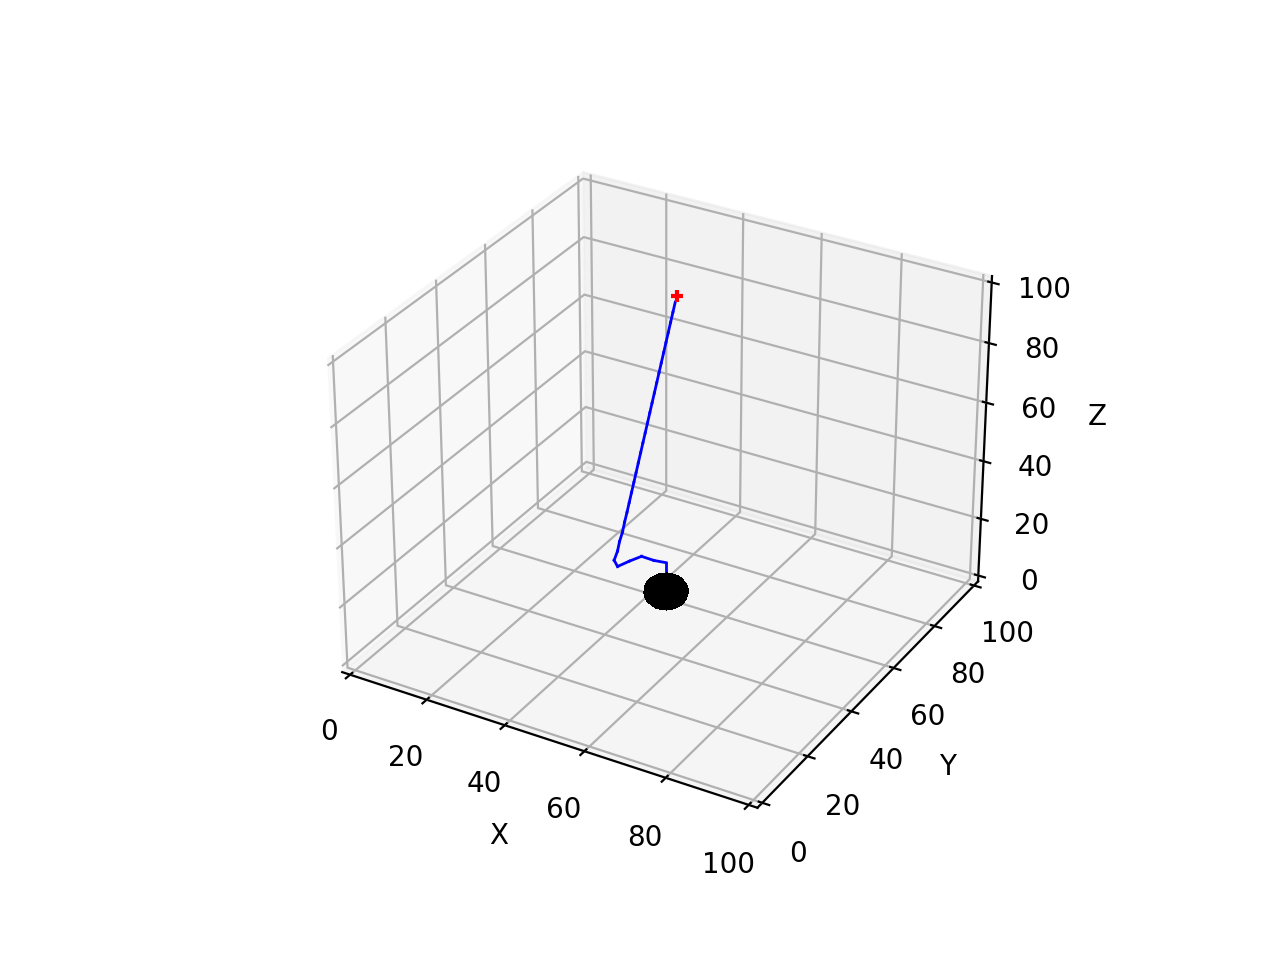

In [4]:
%matplotlib notebook

from neurodevsim.simulator import *

class AGradientFront(Front):
    _fields_ = Front._fields_ + [('sub_ID', ID)]

    def manage_front(self,constellation) :
        if self.order > 0: # dendrite extension
            # generate a random direction along current heading
            rnd_dir = self.unit_heading_sample(width=60)
            # get the attractor stored in sub_ID
            substrate = constellation.substrate_by_id(self.sub_ID)
            # compute local concentration at current time
            n_mols,sdir = diff_gradient_to(self.end,[substrate],constellation.cycle)
            # stronger signal produces less noisy direction vector
            dir_to_attractor = sdir * n_mols + rnd_dir * 1.5
            new_pos = self.end + dir_to_attractor.norm() * 3.
        else: # soma
            # first front: always grow upward, otherwise soma may be in between initial front and attractor
            new_pos = self.orig + Point(0.,0.,2 * self.radius)
            # get substrate ID
            substrates = self.get_substrates(constellation,"attractor",returnID=True)
            # substrates is a list: [(substrate_ID,distance),...]
            # in this case we know it contains only a single (substrate_ID,distance) entry
            if substrates: # store substrate ID so that we do not have to repeat get_substrates call
                self.sub_ID = substrates[0][0]
            else:
                print ("Error: no substrate found")
                self.disable(constellation)
                return
        try:
            new_front = self.add_child(constellation,new_pos,radius=0.5) # make a new front and store it
            new_front.sub_ID = self.sub_ID
            # make front inactive: stops growing -> will not call this method again
            self.disable(constellation)
            return # done for this cycle
        except VolumeError:
            # reached volume border -> stop growth
            self.disable(constellation)
            return # done for this cycle
        except (CollisionError, GridCompetitionError, InsideParentError):
            # in this simple simulation no errors should occur
            self.disable(constellation)
            return # done for this cycle    

if __name__ == '__main__':

    fname = "output/agradient.db"
    sim_volume = [[0., 0., 0.], [100., 100., 100.]]
    admin = Admin_agent(2,fname,sim_volume,neuron_types=[AGradientFront],verbose=0,seed=1,plot=True)

    # add substrate information, in this case a single random point
    x = 20 + 60 * np.random.random()
    y = 20 + 60 * np.random.random()
    # instantiate a substrate 
    sub = Substrate("attractor",Point(x,y,99.),0,1000000000, rate=0., diff_c=30.)
    # add it to the simulation volume
    admin.add_substrate(sub)
    
    admin.add_neurons(AGradientFront,"agrad_neuron",1,[[50,50,10],[50,50,10]],5)

    admin.simulation_loop(40)

    admin.destruction()